# Part 1

Import Python libraries

In [141]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee
#import ipdb

import corner
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Upload the Excel Files containing Transit Fit Parameters

In [2]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')

Define a planetary system.

In [153]:
class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, b, b_err, rprs, rp, lld, qld,
                 timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        self.mass = mass
        self.mass_err = mass_err
        self.radius = radius
        self.radius_err = radius_err
        self.teff = teff
        self.teff_err = teff_err
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        self.ars = 0.0
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
        
        self.lld = lld
        self.qld = qld
        self.diffld = lld - qld
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
        
        
        self.optimize1 = np.empty(0)
       
        #Part 2
        self.dfdt = np.empty(0)
        self.t0fit = np.empty(0)
        self.f0fit = np.empty(0)
        self.dfdtfit = np.empty(0)
        self.sigmafit = np.empty(0)
        
        self.badTrans = 0
        
        self.t0fit_MCMC = np.empty(0) 
        self.f0fit_MCMC = np.empty(0) 
        self.dfdtfit_MCMC = np.empty(0) 
        self.sigmafit_MCMC = np.empty(0) 
       
        self.p_final = 0.0
        self.t0_final = 0.0
        
    def Print(self):
        print("Star {}".format(self.name))

Number of targets that this code will analyze

In [4]:
num = 12

About "tr_window:" Array containing estimates for transit windows (in days). To find them, I initially used a transit window of 20 hours (very big) for all the targets and plotted the folded LC. After visually inspecting it, I made my guesses. Given that these are essentially transit_range*2 (and transit_range is already in days), I chose the transit windows to be twice the range of the transit (I also estimated the range visually, so this process is not perfect. However, it's enough for the code to work and yield good results).

In [199]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.08, 0.08, 0.12, 0.15, 0.08, 0.2, 0.15])
tr_window = transit_range+transit_range # In days

In [200]:
targets = []
for i in range(num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)
    
    lld = targetParams["LLD"][i] # Linear 
    qld = targetParams["QLD"][i] # Quadratic
    
    # Upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, b, b_err, rprs, rp, lld, qld,
               timeLC, fluxLC)
    
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

Run the code

In [201]:
def processStar(star):
    
    goodP = intro(star)  
    mark_transits(star)
    
    fig1 = plt.figure()
    plt.title('Light Curve - Target ' + star.name, fontsize = 14) 
    plt.ylabel('Detrended Flux', fontsize = 14)
    plt.xlabel('Time  (JD)', fontsize = 14)
   
    plotLC(star.name, star.timeLC, star.fluxLC)
    plt.show()
    
    transit_window(star, goodP)
    print "Nº of transits (theory):", len(star.transits), " at ", star.transits
    
    out_trans = out_transit(star)
    oot_fit(star)
    print "Nº of transits (observed):", len(star.transits)
  
    print "Standard deviation of the folded LC:", star.error_foldedLC
    
    fig2 = plt.figure()
    plotLC(star.name, star.dt, star.f_trans) 
    plt.title('Folded LC - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time from midtransit [days]', fontsize = 14)
    plotLC(star.name, star.dt, star.f_trans) #Plot folded LC
    plt.show()
    
    fig3 = plt.figure()
    colTrans(star)

--------- Star  201516974 ---------


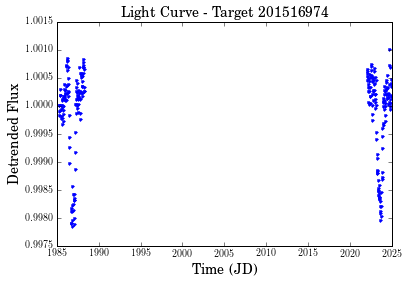

Nº of transits (theory): 2  at  [ 1986.80555162  2023.51544261]
Range of the transit (visual estimate): 0.4
Nº of transits (observed): 2
Standard deviation of the folded LC: 0.000195448084618


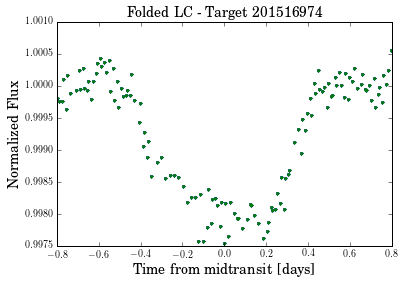

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


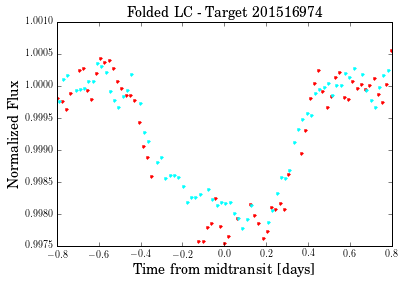

--------- Star  201920032 ---------


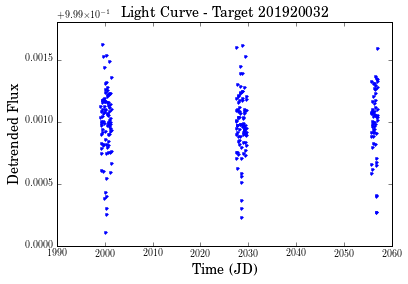

Nº of transits (theory): 3  at  [ 2000.205774    2028.47744553  2056.74911706]
Range of the transit (visual estimate): 0.18
Nº of transits (observed): 3
Standard deviation of the folded LC: 0.000197041111042


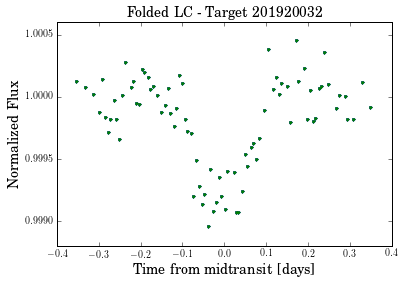

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


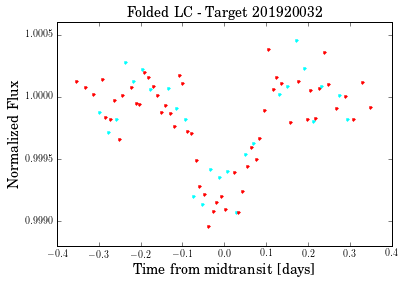

--------- Star  205924614 ---------


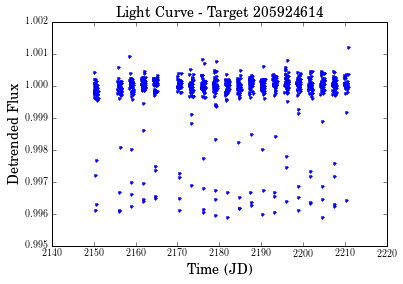

Nº of transits (theory): 21  at  [ 2150.424485    2153.27382604  2156.12316707  2158.97250811  2161.82184914
  2164.67119018  2167.52053121  2170.36987225  2173.21921328  2176.06855432
  2178.91789535  2181.76723639  2184.61657742  2187.46591846  2190.31525949
  2193.16460053  2196.01394156  2198.8632826   2201.71262363  2204.56196467
  2207.4113057 ]
Range of the transit (visual estimate): 0.07
Nº of transits (observed): 19
Standard deviation of the folded LC: 0.00013511676645


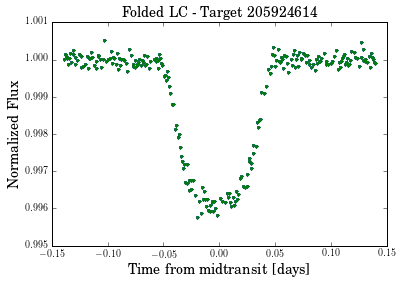

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


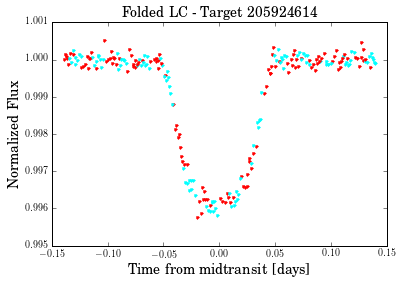

--------- Star  205985357 ---------


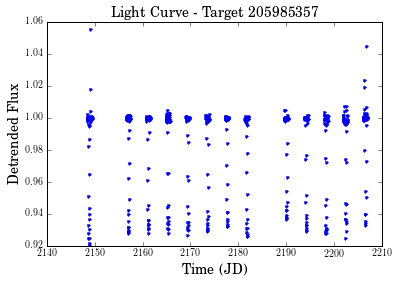

Nº of transits (theory): 15  at  [ 2148.728257    2152.85666526  2156.98507352  2161.11348177  2165.24189003
  2169.37029829  2173.49870655  2177.6271148   2181.75552306  2185.88393132
  2190.01233958  2194.14074784  2198.26915609  2202.39756435  2206.52597261]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 13
Standard deviation of the folded LC: 0.013007228009


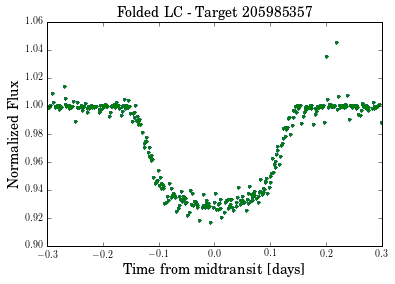

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


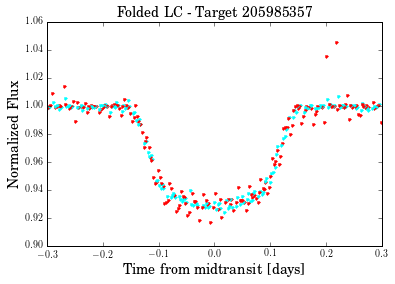

--------- Star  206029314 ---------


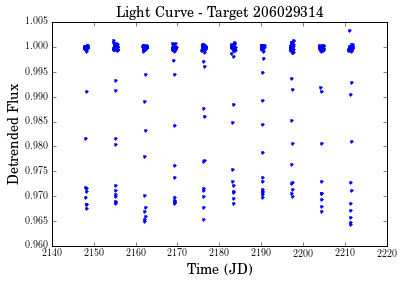

Nº of transits (theory): 10  at  [ 2148.06875     2155.09479332  2162.12083664  2169.14687996  2176.17292329
  2183.19896661  2190.22500993  2197.25105325  2204.27709657  2211.30313989]
Range of the transit (visual estimate): 0.12
Nº of transits (observed): 10
Standard deviation of the folded LC: 0.000358618816675


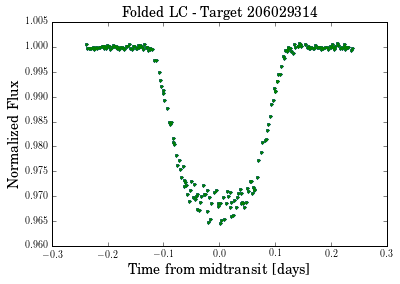

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


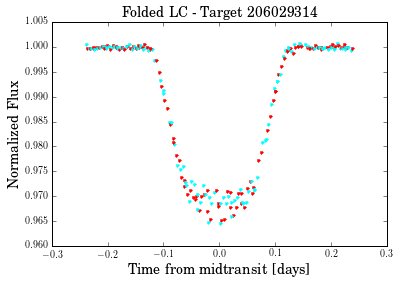

--------- Star  206038483 ---------


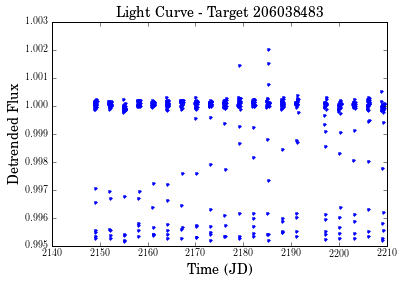

Nº of transits (theory): 21  at  [ 2149.05976     2152.06234098  2155.06492195  2158.06750293  2161.07008391
  2164.07266488  2167.07524586  2170.07782684  2173.08040781  2176.08298879
  2179.08556977  2182.08815074  2185.09073172  2188.09331269  2191.09589367
  2194.09847465  2197.10105562  2200.1036366   2203.10621758  2206.10879855
  2209.11137953]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 20
Standard deviation of the folded LC: 0.000101449826621


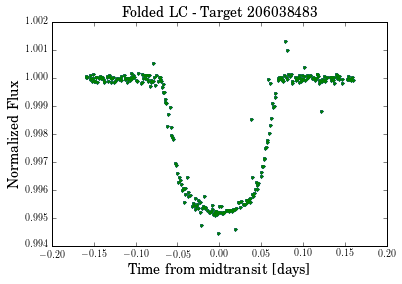

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


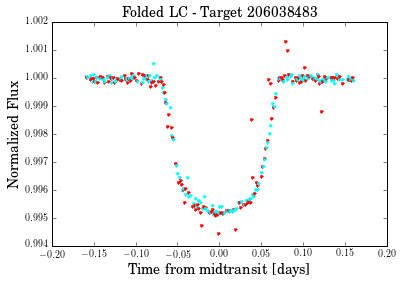

--------- Star  206061524 ---------


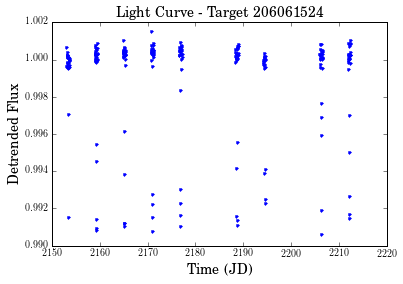

Nº of transits (theory): 11  at  [ 2153.323933    2159.20362989  2165.08332678  2170.96302367  2176.84272056
  2182.72241745  2188.60211433  2194.48181122  2200.36150811  2206.241205
  2212.12090189]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 9
Standard deviation of the folded LC: 0.000223463090685


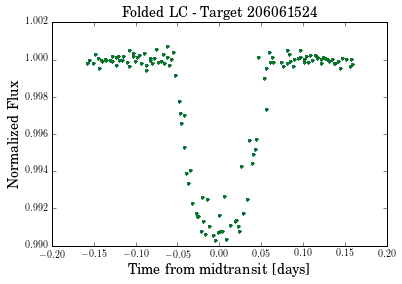

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


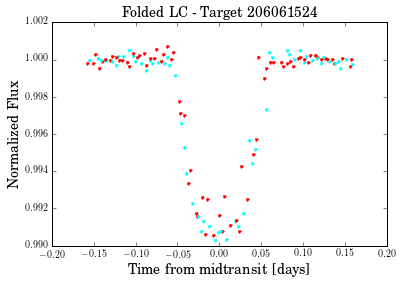

--------- Star  206082454 ---------


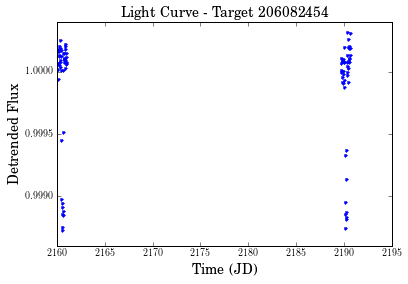

Nº of transits (theory): 2  at  [ 2160.54021572  2190.16619823]
Range of the transit (visual estimate): 0.12
Nº of transits (observed): 2
Standard deviation of the folded LC: 7.07237640894e-05


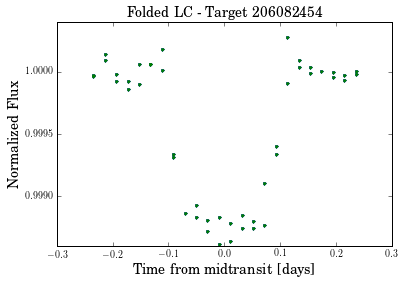

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


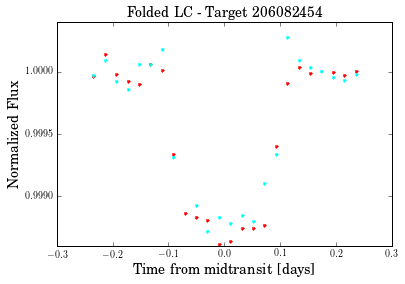

--------- Star  206155547 ---------


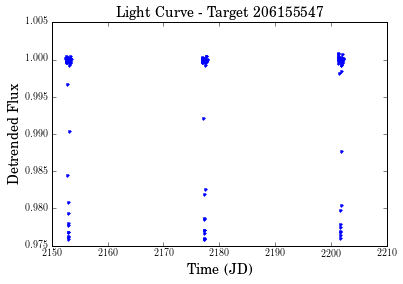

Nº of transits (theory): 3  at  [ 2152.884148    2177.27135138  2201.65855475]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 3
Standard deviation of the folded LC: 0.000307031519688


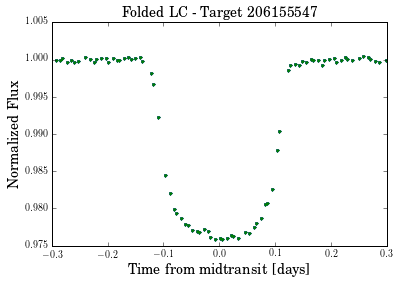

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


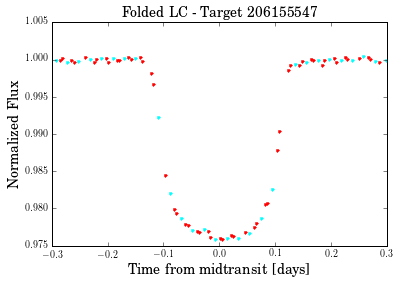

--------- Star  206245553 ---------


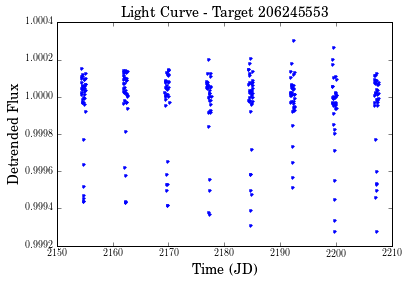

Nº of transits (theory): 8  at  [ 2154.672782    2162.16773498  2169.66268797  2177.15764095  2184.65259394
  2192.14754692  2199.64249991  2207.13745289]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 8
Standard deviation of the folded LC: 3.27386699631e-05


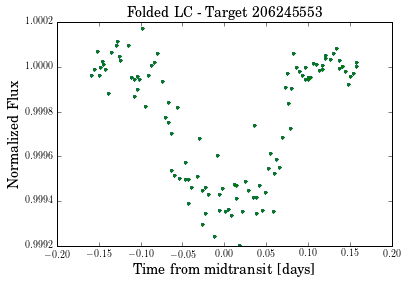

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


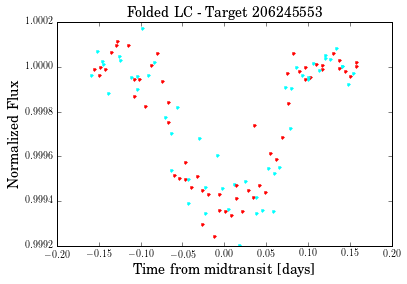

--------- Star  206247743 ---------


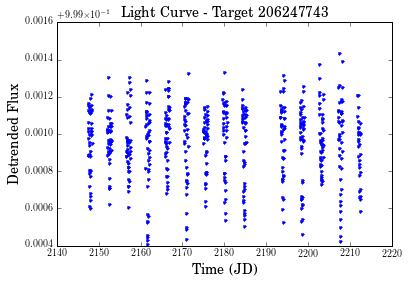

Nº of transits (theory): 15  at  [ 2147.821002    2152.42382923  2157.02665646  2161.6294837   2166.23231093
  2170.83513816  2175.43796539  2180.04079262  2184.64361985  2189.24644709
  2193.84927432  2198.45210155  2203.05492878  2207.65775601  2212.26058325]
Range of the transit (visual estimate): 0.2
Nº of transits (observed): 14
Standard deviation of the folded LC: 7.1631588773e-05


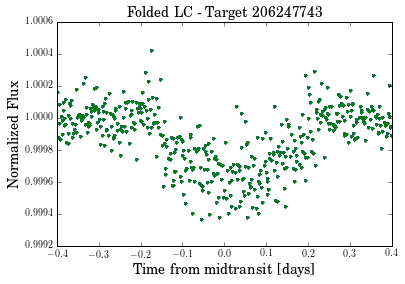

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


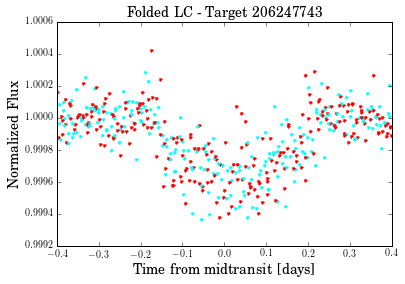

--------- Star  206311743 ---------


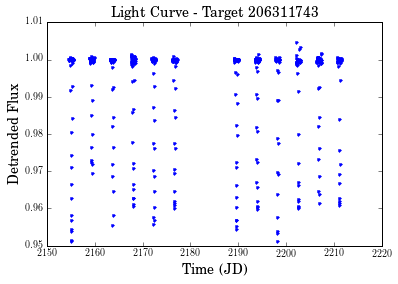

Nº of transits (theory): 14  at  [ 2155.041924    2159.35348755  2163.6650511   2167.97661465  2172.2881782
  2176.59974175  2180.9113053   2185.22286885  2189.5344324   2193.84599595
  2198.1575595   2202.46912305  2206.7806866   2211.09225015]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 12
Standard deviation of the folded LC: 0.000332563179184


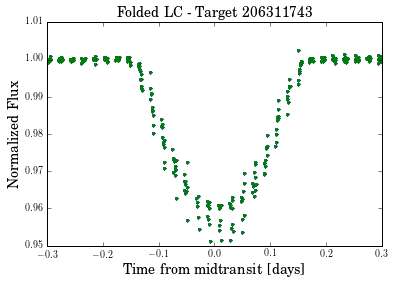

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


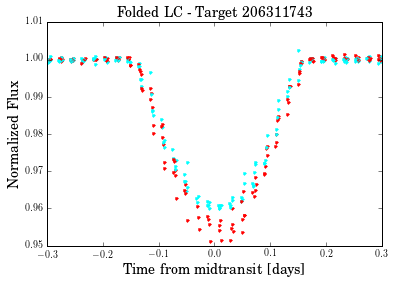

In [202]:
for star in targets:
    print "--------- Star ", star.name, "---------"
    processStar(star)

In [203]:
def intro(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

Identify transits in data

In [192]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -20
    maxepoch = 20
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits

In [193]:
def plotLC(name, time, flux):
    plt.plot(time,flux,'.')

In [194]:
def transit_window(star, goodP):
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

In [195]:
def out_transit(star):
    print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

For each individual transit: perform a linear fit to the out-of-transit regions.

In [196]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
        
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0,len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Correct Flux again (needed if we had to some star.transits didn't have data)
    
    corFlux2 = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 
    
    #Calculate the standard dev. of the folded LC 
    
    star.f_trans = corFlux2
    err_folded = np.std(corFlux2[outsideBool])
    star.error_foldedLC = err_folded

Color-code odd/even transits

In [197]:
def colTrans(star):
    print "Color-coding of odd and even transits. They're shown in cyan and red, respectively."
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        if i % 2 == 0: #even transit
            plt.plot(star.dt[transitBool],star.f_trans[transitBool], '.', color = 'red', label = 'Even')
        else:
            plt.plot(star.dt[transitBool],star.f_trans[transitBool], '.', color = 'cyan', label = 'Odd')
   
    plt.title('Folded LC - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time from midtransit [days]', fontsize = 14)
    plt.show()

## Theoretical Model

Optimization for  201516974
Optimization terminated successfully.
         Current function value: -1046.862905
         Iterations: 920
         Function evaluations: 1380


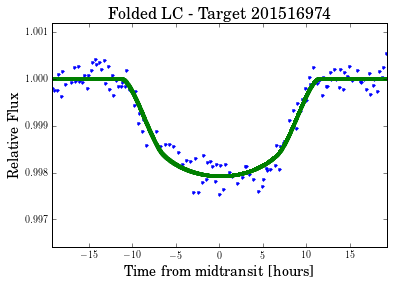

[  2.67994689e-03   8.86574627e-01   2.73996355e-03   1.15493060e-04
   8.39555778e-01   1.24554273e-02   1.52836535e+00   1.00002832e+00]
0.000195448084618
Optimization for  201920032
Optimization terminated successfully.
         Current function value: -678.877483
         Iterations: 847
         Function evaluations: 1294


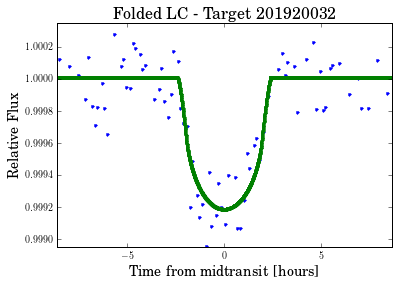

[  5.91061709e-04   1.26180970e-02  -8.98774325e-04   7.54497551e-08
   9.21300792e-01   1.00251687e+00   7.87116845e-01   1.00001607e+00]
0.000197041111042
Optimization for  205924614
Optimization terminated successfully.
         Current function value: -2000.596197
         Iterations: 867
         Function evaluations: 1260


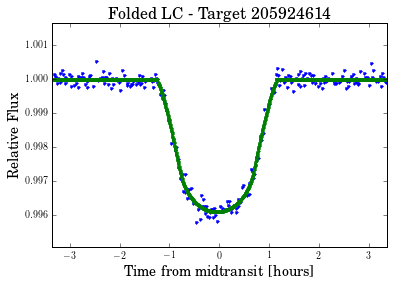

[  3.03538973e-03   2.26402293e-01  -2.25079474e-03   8.78535446e-05
   8.64335363e-01   6.97219569e-01   6.83510129e-01   9.99997603e-01]
0.00013511676645
Optimization for  205985357
Optimization terminated successfully.
         Current function value: -1418.309391
         Iterations: 699
         Function evaluations: 1066


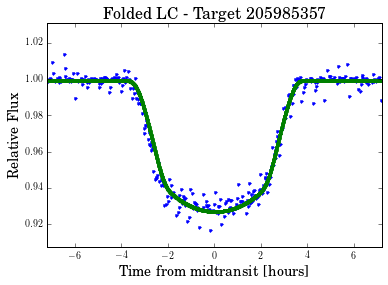

[  6.12236456e-02   1.22645236e-03   1.37703004e-03   1.27956622e-03
   4.00000107e-01   3.15341226e-01   1.33235252e+00   9.99428369e-01]
0.013007228009
Optimization for  206029314
Optimization terminated successfully.
         Current function value: -1306.030610
         Iterations: 968
         Function evaluations: 1447


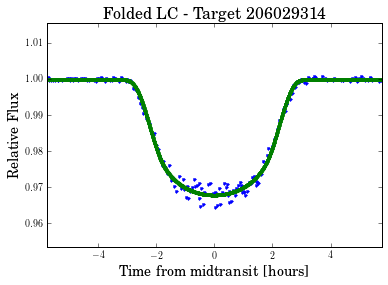

[  2.55689850e-02   4.57475213e-01  -5.97821642e-04   1.07470113e-03
   9.99998601e-01   6.07062784e-01   1.33229397e+00   9.99952633e-01]
0.000358618816675
Optimization for  206038483
Optimization terminated successfully.
         Current function value: -2193.724554
         Iterations: 778
         Function evaluations: 1179


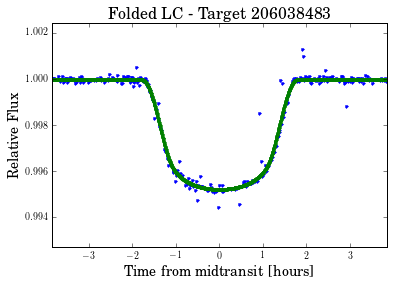

[  4.40418304e-03   6.61462942e-01   2.74438097e-05   2.68753992e-04
   7.59365231e-01   9.81269137e-01   1.44622892e+00   1.00001487e+00]
0.000101449826621
Optimization for  206061524


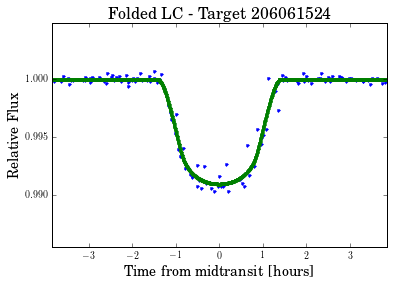

[  7.21703158e-03   2.89439895e-01  -4.43228778e-04   5.48485439e-04
   8.76554114e-01   6.53002171e-01   6.15794457e-01   9.99989454e-01]
0.000223463090685
Optimization for  206082454
Optimization terminated successfully.
         Current function value: -406.513164
         Iterations: 502
         Function evaluations: 761


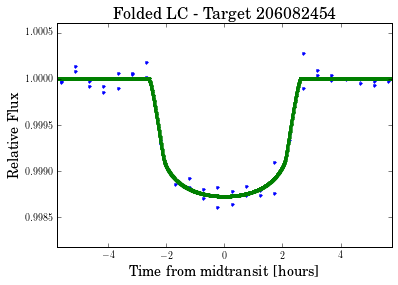

[  1.06909359e-03   1.04293231e-01  -7.63384574e-05   5.15121094e-05
   6.32163036e-01   9.09536875e-01   8.15077638e-01   1.00001473e+00]
7.07237640894e-05
Optimization for  206155547
Optimization terminated successfully.
         Current function value: -615.109160
         Iterations: 1025
         Function evaluations: 1548


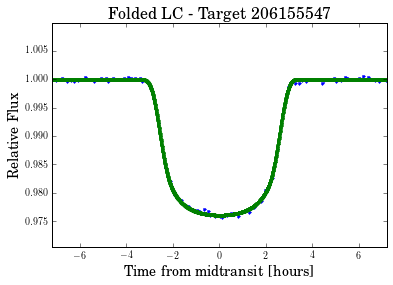

[  1.92403243e-02   1.03207533e-01   2.96402378e-04   1.03584163e-08
   8.98741369e-01   1.16286571e+00   1.08618698e+00   9.99980836e-01]
0.000307031519688
Optimization for  206245553
Optimization terminated successfully.
         Current function value: -984.582623
         Iterations: 637
         Function evaluations: 963


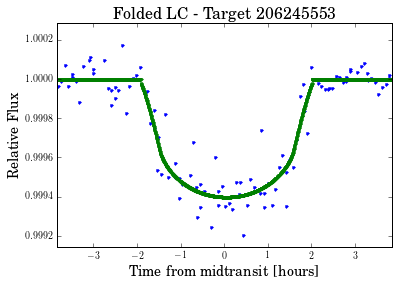

[  4.68221008e-04   1.90634323e-01   1.91985840e-03   7.86372277e-05
   7.53288557e-01   1.06279555e+00   1.03094795e+00   1.00000001e+00]
3.27386699631e-05
Optimization for  206247743
Optimization terminated successfully.
         Current function value: -3843.120710
         Iterations: 920
         Function evaluations: 1409


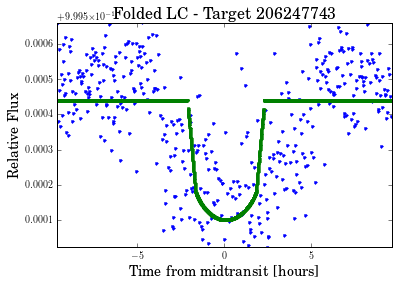

[  2.89905214e-04   3.03775766e-02   3.11234754e-03   1.42644745e-04
   4.00000421e-01   6.87720766e-01   1.15897315e+00   9.99940022e-01]
7.1631588773e-05
Optimization for  206311743


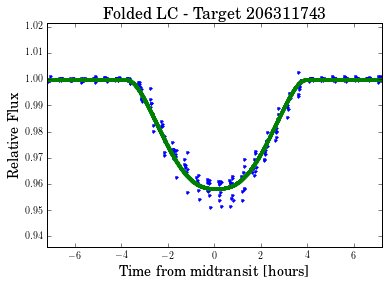

[ 0.04315372  0.78767958  0.00297752  0.00222297  0.4317732   0.01603963
  0.68394142  1.00008795]
0.000332563179184


In [204]:
for star in targets:
    fixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
    print "Optimization for ", star.name
    opt(star, fixed)
    results(star)

Calculates the log of the likelihood of the transit model being the right model given the following parameters:

In [19]:
"""
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    
    
    Gaussian prior: We assume that the parameter we want to fit 
    is constrained within the range centered on the maximum value of a 
    Gaussian distribution. 
    
"""   

def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
 
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = pmass, radius = pradius))
    
    body = transit.Body(r = np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    
    s.add_body(body)
    
    sigma2 = errorLC**2 + sigma**2
    
    ftheo = s.light_curve(timeLC, texp = tKep, tol=1e-08, maxdepth = 4)
    ftheo = ftheo - 1.0 + f0
    
    # Chi Squared
    return -0.5*(np.sum(((fluxLC-ftheo)**2)/sigma2 - np.log(1.0/sigma2)) +
                 ((pmass-mass)/masserr)**2 + 
                 ((pradius-radius)/radiuserr)**2)

def lnprior(theta): # This function ensures that estimates make physical sense.
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    if (0.4 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius > 0) and (pdepth > 0):
        return 0.0 
    
    return -np.inf

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [20]:
def opt(star, allfixed):
    nll = lambda *args: -lnprob(*args)

    # Minimization of the function "nll"
    result = op.minimize(nll, [1.2*star.depth, star.b, 0.0, 0.0, 0.6, star.mass, star.radius, 1.0], 
                             args = (star.dt, star.f_trans, star.error_foldedLC, allfixed),
                             options = {'disp': True}, 
                             method  ='Nelder-Mead')
    
    # Store best estimates in "result["x"]
    depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

    star.optimize1 = result["x"]

    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + star.diffld)
    u2_ml = sumLD_ml - u1_ml

    # Compute each transit LC integrated over a Kepler long cadence exposure time 
    # with the result derived from optimization and plot theoretical model and observed data.

    s = transit.System(transit.Central(mu1 = u1_ml, mu2 = u2_ml, mass = mass_ml, radius = radius_ml))

    body = transit.Body(r = np.sqrt(depth_ml)*radius_ml, period = star.per, t0 = t0_ml, 
                            b = b_ml, e = star.ecc)

    s.add_body(body)
    t_theory = np.arange(-1.0, 1.0, tKep*0.01)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 4)
    f_theory = f_theory - 1.0 + f0_ml

    fig3 = plt.figure()
    plotLC(star.name, 24.0*star.dt, star.f_trans) #Plot folded LC (note: dt is now in hours)
    plotLC(star.name, 24.0*t_theory, f_theory)
    plt.title('Folded LC - Target ' + star.name, fontsize = 16)
    plt.xlabel('Time from midtransit [hours]', fontsize=14)
    plt.ylabel('Relative Flux', fontsize = 14)
    plt.xlim([-star.transWindow*24.0, star.transWindow*24.0]) 
    plt.ylim([1-star.depth*1.5, star.depth*0.5+1]) 

    plt.show()

In [21]:
def results(star): #Print the best guesses & save them in a text file.
    print star.optimize1
    print star.error_foldedLC

    np.savetxt('1_'+star.name+'guesses.txt', (star.optimize1[0], star.optimize1[1], 
                                              star.optimize1[2], star.optimize1[3], 
                                              star.optimize1[4], star.optimize1[5], 
                                              star.optimize1[6], star.optimize1[7], 
                                              star.error_foldedLC), 
               fmt = '%.4e', delimiter='   ', header = """Best fit parameters. These are: 
               Depth, Impact parameter, time of transit, sigma (additional white noise),
               Sum of LD coefficients,  Mass of the star, Radius of the star (gaussian priors
               on both), the out of eclipse flux, and the standard deviation of the 
               out-of-transit flux.""") 

# Part 2

Assume stellar flux changes over time.

In [22]:
def fluxchange(star):

    dfdt_ml = []
    guess = []
    
    for i in range (len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        k = np.polyfit(star.t_trans[outsideBool], star.f_trans[outsideBool], 1)
        dFdT = k[0]
        guess.append(dFdT)

    dfdt_ml = np.array(guess)
    star.dfdt = dfdt_ml

In [23]:
def loadParams(parameters, star):
    depth_ml = parameters[0]
    b_ml = parameters[1]
    sumLD_ml = parameters[4]
    mass_ml = parameters[5] #Best guess for mass of the star
    radius_ml = parameters[6] #Best guess for radius of the star
    f0_ml = parameters[7] # Out-of-transit flux
    star.error_foldedLC = parameters[8]

    allfix = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep, 
              depth_ml, b_ml, sumLD_ml, mass_ml, radius_ml]
    
    return allfix

Simply shows the fitting results obtained for each star in Part 1. 

In [46]:
print "--------------- Fitting results from Part 1 ---------------:"
print "       1) Depth"
print "       2) b"
print "       3) Sum of LD"
print "       4) Stellar mass"
print "       5) Stellar radius"
print "       6) Out-of-transit flux"
print "       7) Error folded LC"
print "         "

for star in targets:
    fluxchange(star)
    parameters = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1)
    allfixed = loadParams(parameters, star)
    print "Star", star.name,":"
    print parameters
    print "        "

--------------- Fitting results from Part 1 ---------------:
       1) Depth
       2) b
       3) Sum of LD
       4) Stellar mass
       5) Stellar radius
       6) Out-of-transit flux
       7) Error folded LC
         
Star 201516974 :
[  2.67990000e-03   8.86570000e-01   2.74000000e-03   1.15490000e-04
   8.39560000e-01   1.24550000e-02   1.52840000e+00   1.00000000e+00
   1.95450000e-04]
        
Star 201920032 :
[  5.91060000e-04   1.26180000e-02  -8.98770000e-04   7.54500000e-08
   9.21300000e-01   1.00250000e+00   7.87120000e-01   1.00000000e+00
   1.97040000e-04]
        
Star 205924614 :
[  3.03540000e-03   2.26400000e-01  -2.25080000e-03   8.78540000e-05
   8.64340000e-01   6.97220000e-01   6.83510000e-01   1.00000000e+00
   1.35120000e-04]
        
Star 205985357 :
[  6.12240000e-02   1.22650000e-03   1.37700000e-03   1.27960000e-03
   4.00000000e-01   3.15340000e-01   1.33240000e+00   9.99430000e-01
   1.30070000e-02]
        
Star 206029314 :
[  2.55690000e-02   4.574800

In [207]:
for star in targets:
    fluxchange(star)
    parameters = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1)
    allfixed = loadParams(parameters, star)
    eachTrans(star, allfixed, parameters)
    print "----- Fitting for Star ", star.name, ": COMPLETED. -----"
    print "       Transit time estimates", star.t0fit
    print "       Out-of-Transit Flux:", star.f0fit
    print "       dF/dT:", star.dfdtfit
    print "       sigma:", star.sigmafit
    print "        "

----- Fitting for Star  201516974 : COMPLETED. -----
       Transit time estimates [1986.7952929032567, 2023.5184409699089]
       Out-of-Transit Flux: [0.99994812636120678, 1.0000964052430836]
       dF/dT: [-1.2773481474660324e-14, -7.0179528786411821e-14]
       sigma: [0.00023517247875040552, 0.00018545521273764494]
        
----- Fitting for Star  201920032 : COMPLETED. -----
       Transit time estimates [2000.2050659323204, 2028.4665486353394, 2056.7477477446446]
       Out-of-Transit Flux: [1.0000153217325192, 0.99999998831826298, 1.0000146595213288]
       dF/dT: [-9.3700288173415166e-16, -1.6545063059191258e-14, 9.7483161484955268e-14]
       sigma: [0.00013951913652869371, 0.00019703936587584984, 0.00015442289168600824]
        
----- Fitting for Star  205924614 : COMPLETED. -----
       Transit time estimates [2150.4241130872933, 2156.1220119544191, 2158.9715060714307, 2161.820679242287, 2164.6680188198779, 2170.3675279023137, 2173.2169125561186, 2176.0654939893143, 2178.91

For each transit in the LC of a star, find a best estimate for t0 (transit time), f0 (out-of-transit flux), dF/dT, and sigma. This function is called for every star.

In [118]:
def eachTrans(star, allfixed, parameters):
    
    t0_fit = []
    f0_fit = []
    dfdt_fit = []
    sigma_fit = []
    
    for i in range(len(star.transits)):
        
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag==i)

        dt_i = star.dt[transitBool] # timeTrans-midTrans for transit i
        t_i = star.t_trans[transitBool] # timeTrans for transit i
        corFlux_i = star.f_trans[transitBool] #corrected flux for transit i.

        aux1, aux2, aux3, aux4 = opt2(star, i, t_i, corFlux_i, 0.1*star.error_foldedLC, allfixed, parameters)
        
        t0_fit.append(aux1)
        f0_fit.append(aux2)
        dfdt_fit.append(aux3)
        sigma_fit.append(aux4)
    
    star.t0fit = t0_fit
    star.f0fit = f0_fit
    star.dfdtfit = dfdt_fit
    star.sigmafit = sigma_fit

Calculates the log of the likelihood of the transit model being the right model using four free parameters: t0 (transit time), the flux outside of the transit, df/dt, and sigma (pt0_i, f0_i, dfdt_i, sigma_i). The index i represents the transit being analyzed. Note: theta[0] = pt0_i, theta[1]=f0_i, theta[2]=dfdt_i, theta[3]=sigma_i.

In [208]:
def lnlike2(theta, numTrans, timeLC, fluxLC, errorLC, allfixed):
    
    pt0_i, f0_i, dfdt_i, sigma_i = theta 
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sumLD_ml, mass_ml, radius_ml = allfixed 
    
    u1 = 0.5*(sumLD_ml+diffLD) 
    u2 = sumLD_ml-u1
    
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = mass_ml, radius = radius_ml))
    
    body = transit.Body(r =np.sqrt(depth_ml)*radius_ml, period = period, t0 = pt0_i, b = np.abs(b_ml), e = ecc)
    
    s.add_body(body)
    
    sigma2 = errorLC**2 + sigma_i**2
    
    ftheo = s.light_curve(timeLC, texp = tKep, tol = 1e-08, maxdepth = 4)  
    ftheo = ftheo - 1 + f0_i + (dfdt_i*(timeLC - pt0_i)) 
    
    # Chi Squared
    return -0.5*(np.sum(((fluxLC-ftheo)**2)/sigma2 - np.log(1.0/sigma2)))

def opt2 (star, transNum, timeLC, fluxLC, errorLC, allfixed, parameters): 
    
    n2 = lambda *args: -lnlike2(*args)
    
    # Note: args are given by function each trans.
    result = op.minimize(n2, [star.transits[transNum], parameters[7], star.dfdt[transNum], 
                              star.error_foldedLC], args = (transNum, timeLC, fluxLC, errorLC, allfixed), 
                         options={'disp': False}, method='Nelder-Mead')
                            
    t0_fit, f0_fit, dfdt_fit, sigma_fit = result["x"]
    return (t0_fit, f0_fit, dfdt_fit, sigma_fit)

Compute each transit LC integrated over a Kepler long cadence exposure time with the result derived from optimization. Then, plot it.

0 ) Star  201516974 has 2 transits. Fitting results:


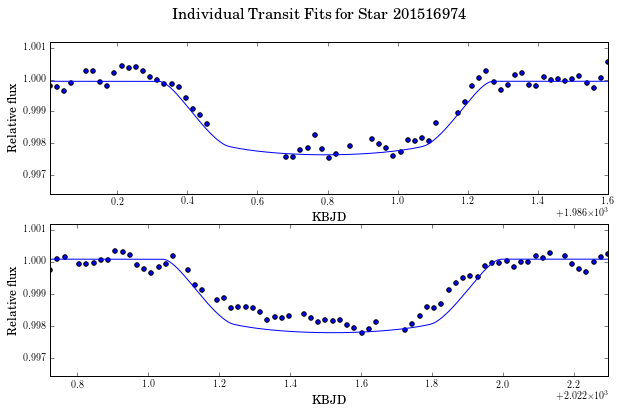

1 ) Star  201920032 has 3 transits. Fitting results:


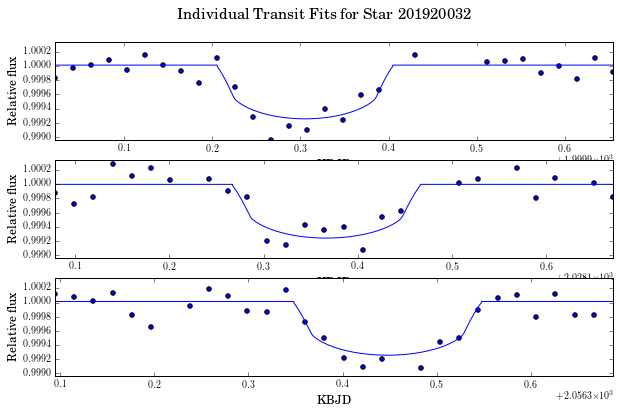

2 ) Star  205924614 has 19 transits. Fitting results:


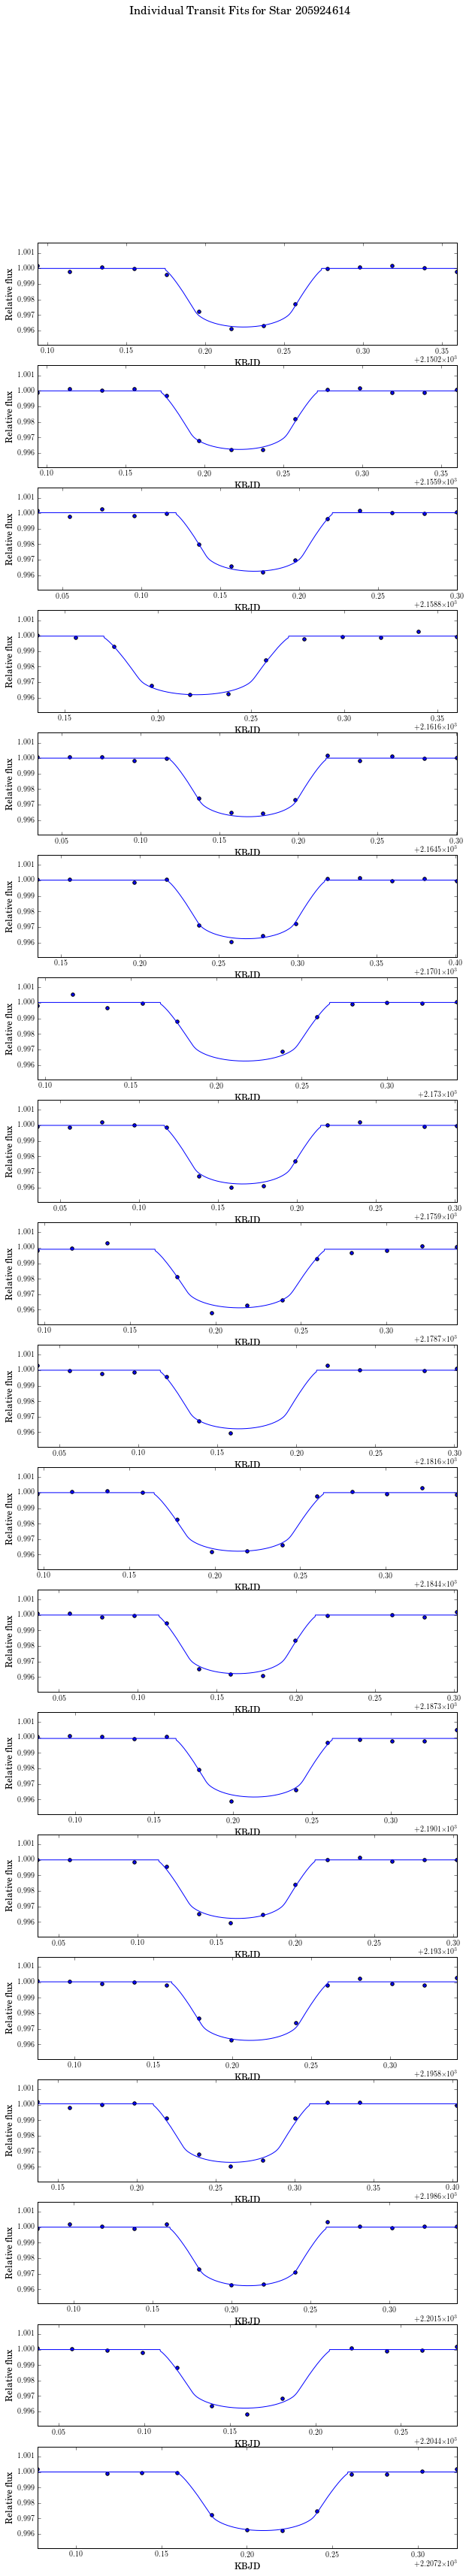

3 ) Star  205985357 has 13 transits. Fitting results:


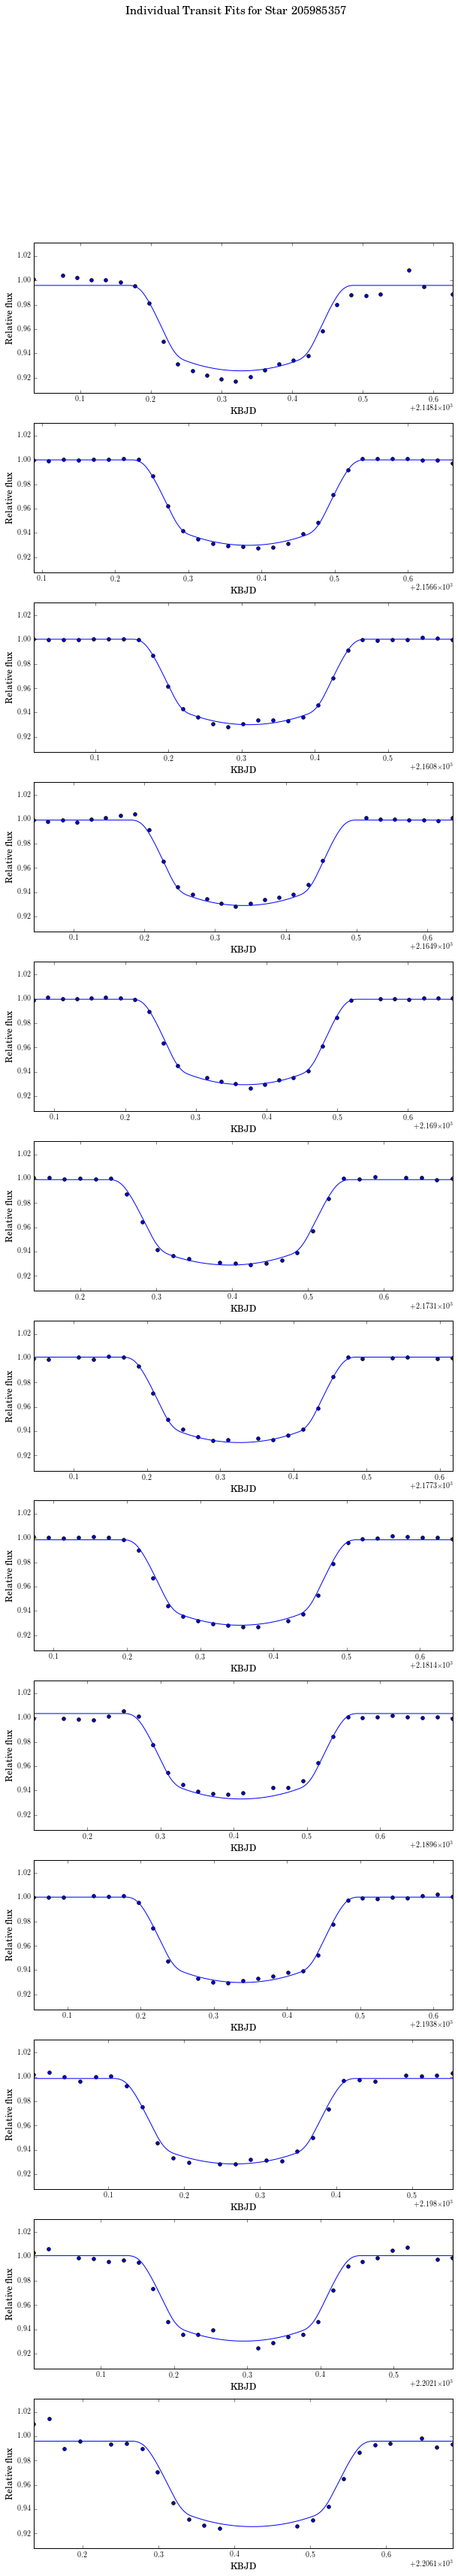

4 ) Star  206029314 has 10 transits. Fitting results:


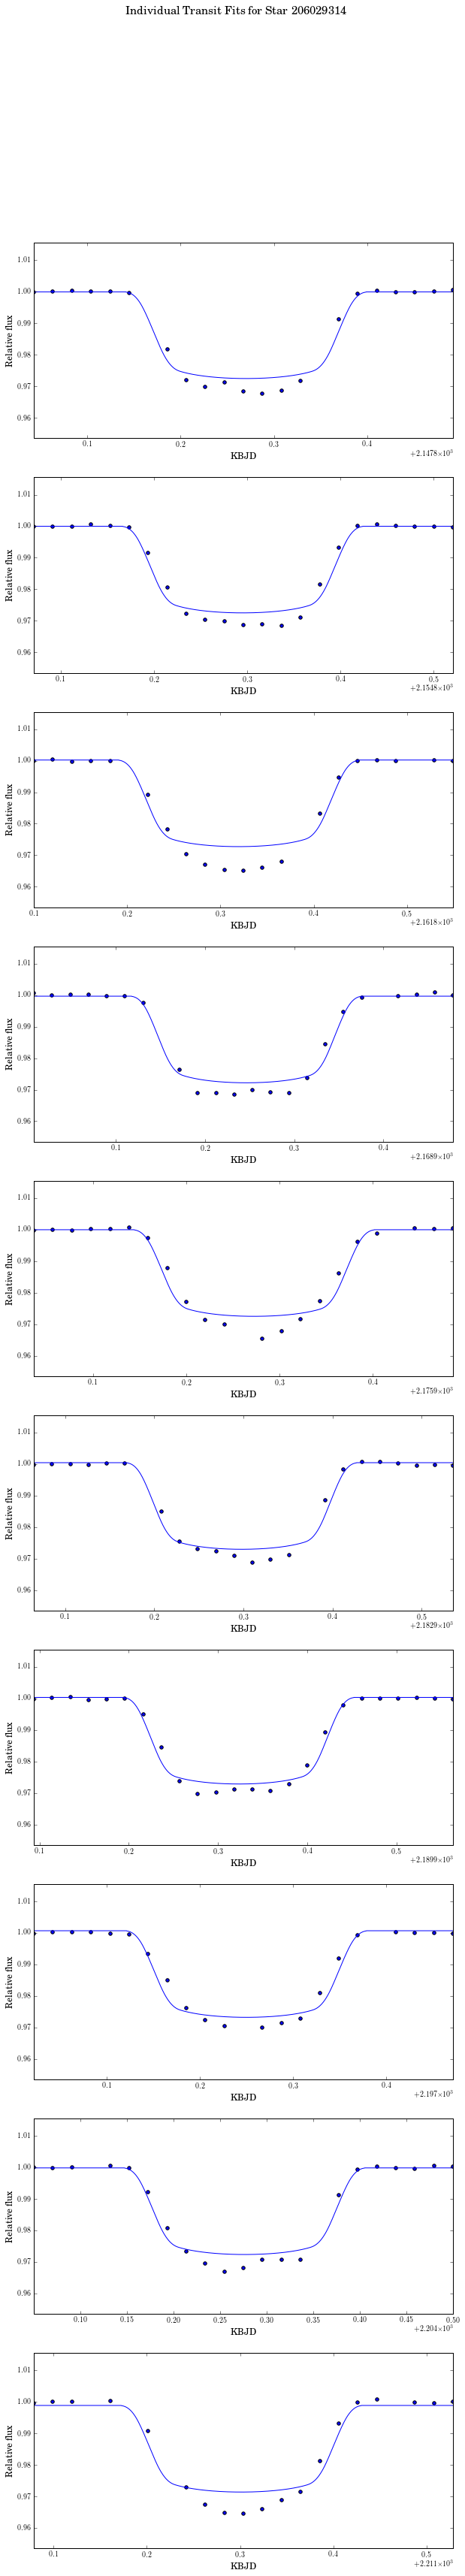

5 ) Star  206038483 has 20 transits. Fitting results:


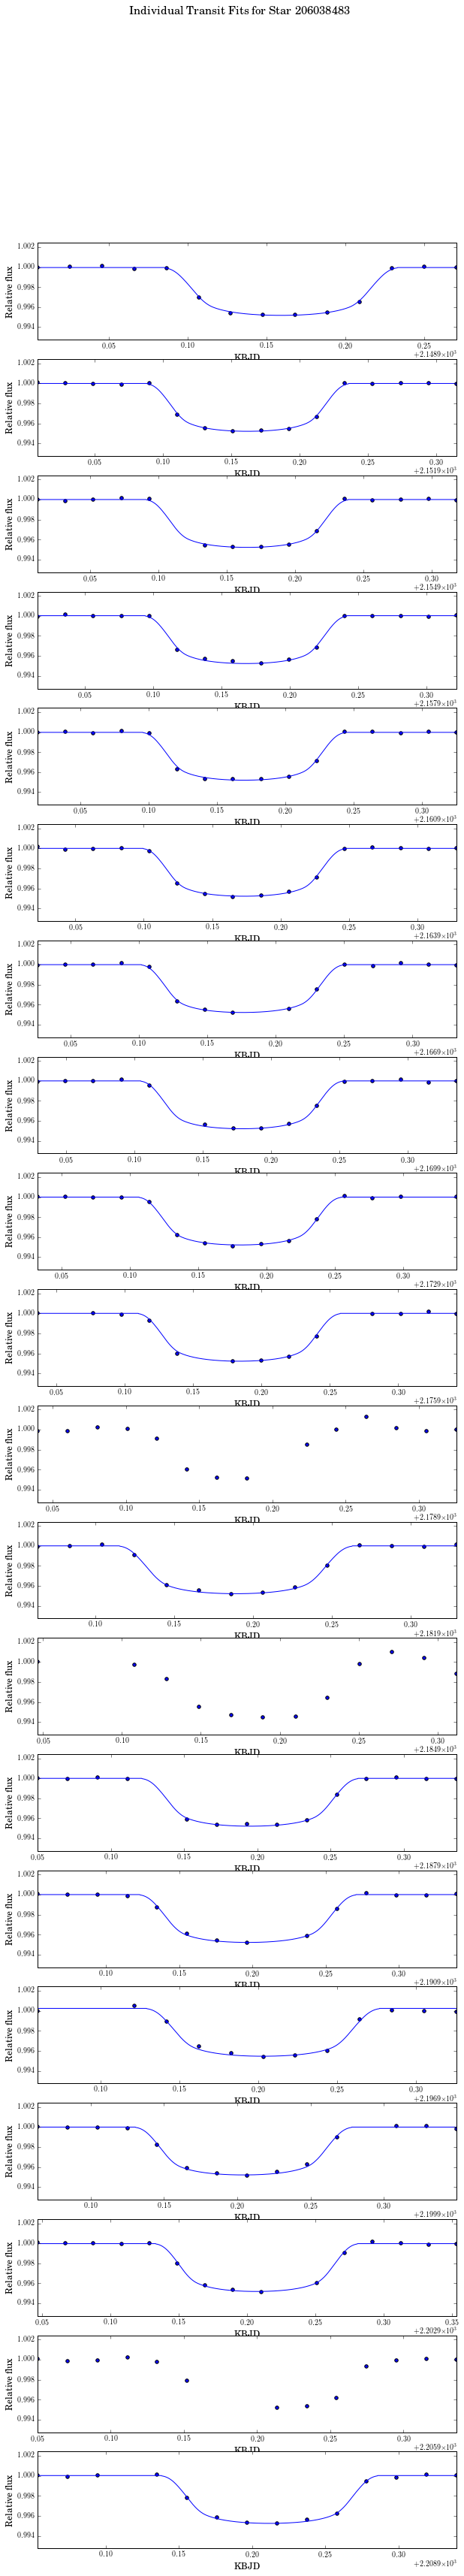

6 ) Star  206061524 has 9 transits. Fitting results:


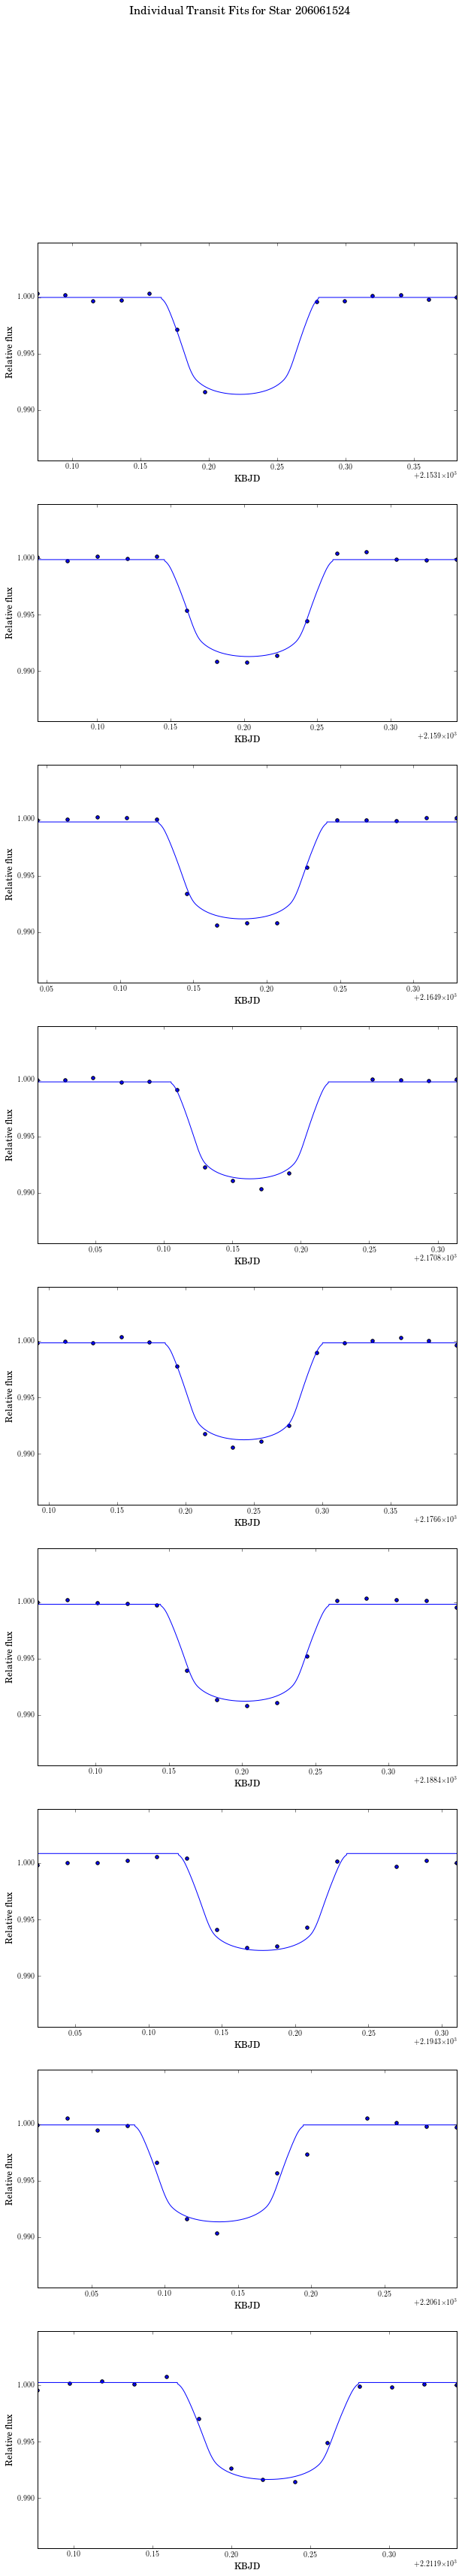

7 ) Star  206082454 has 2 transits. Fitting results:


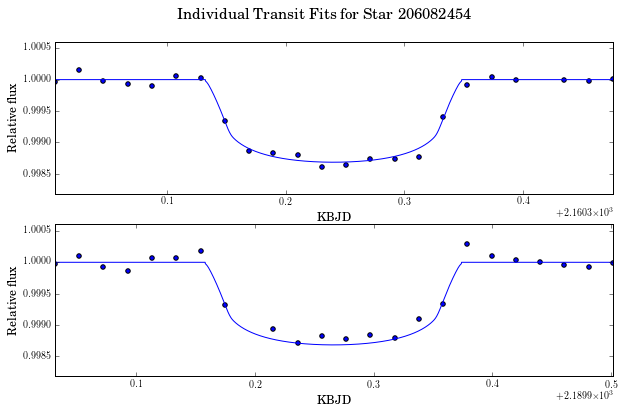

8 ) Star  206155547 has 3 transits. Fitting results:


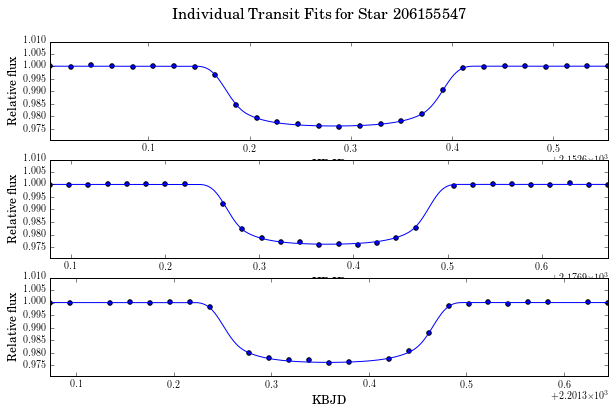

9 ) Star  206245553 has 8 transits. Fitting results:


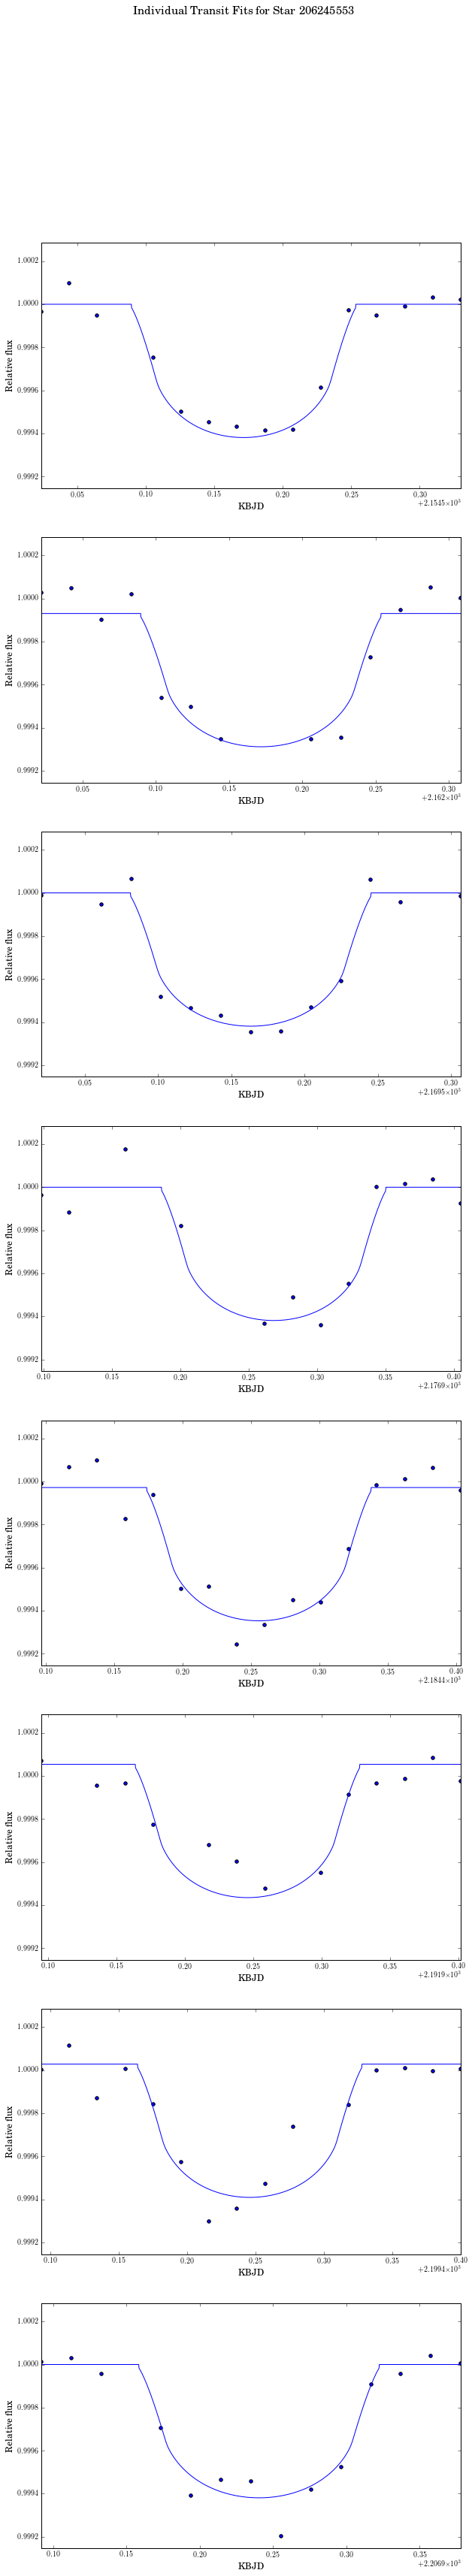

10 ) Star  206247743 has 14 transits. Fitting results:


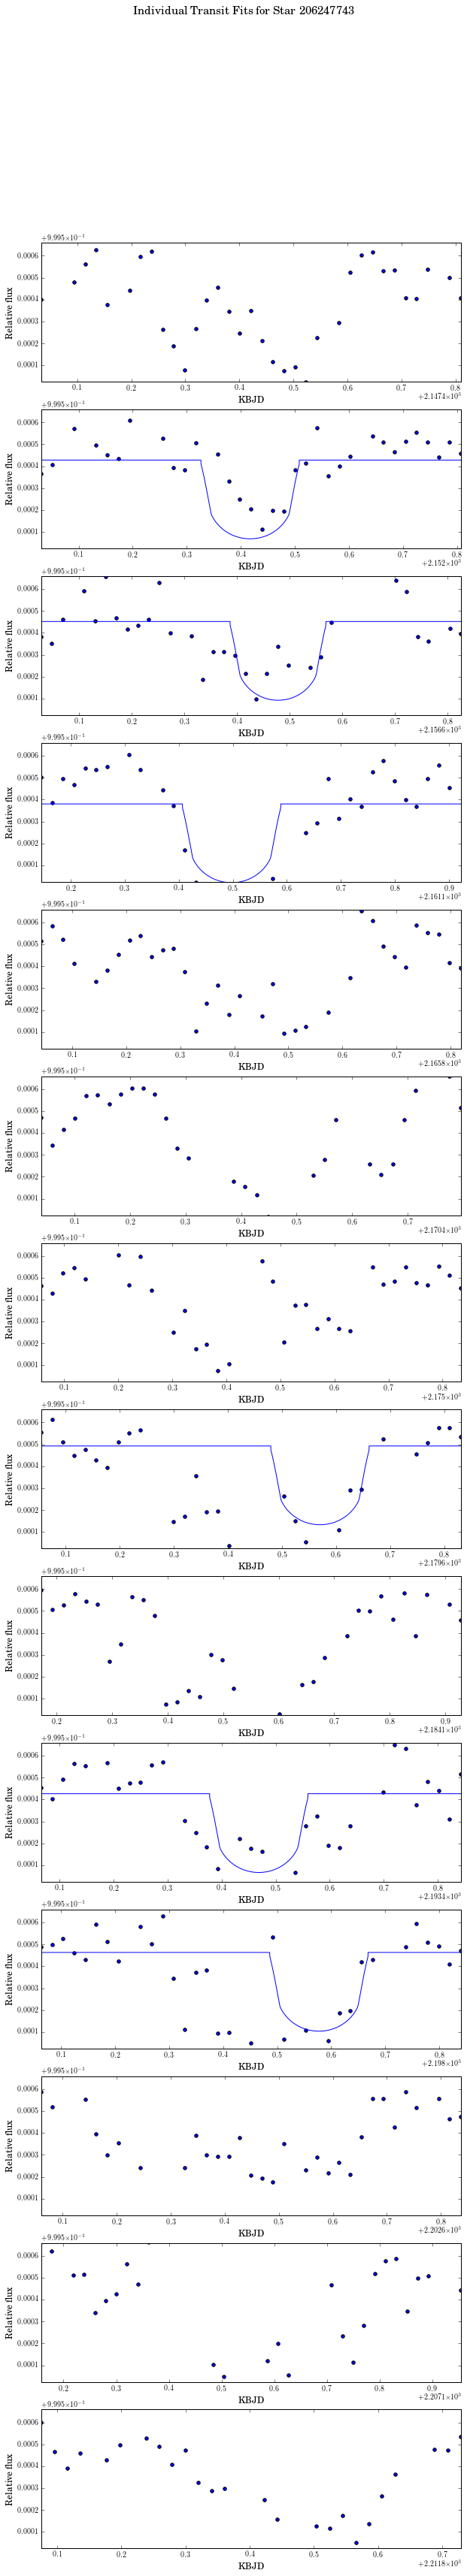

11 ) Star  206311743 has 12 transits. Fitting results:


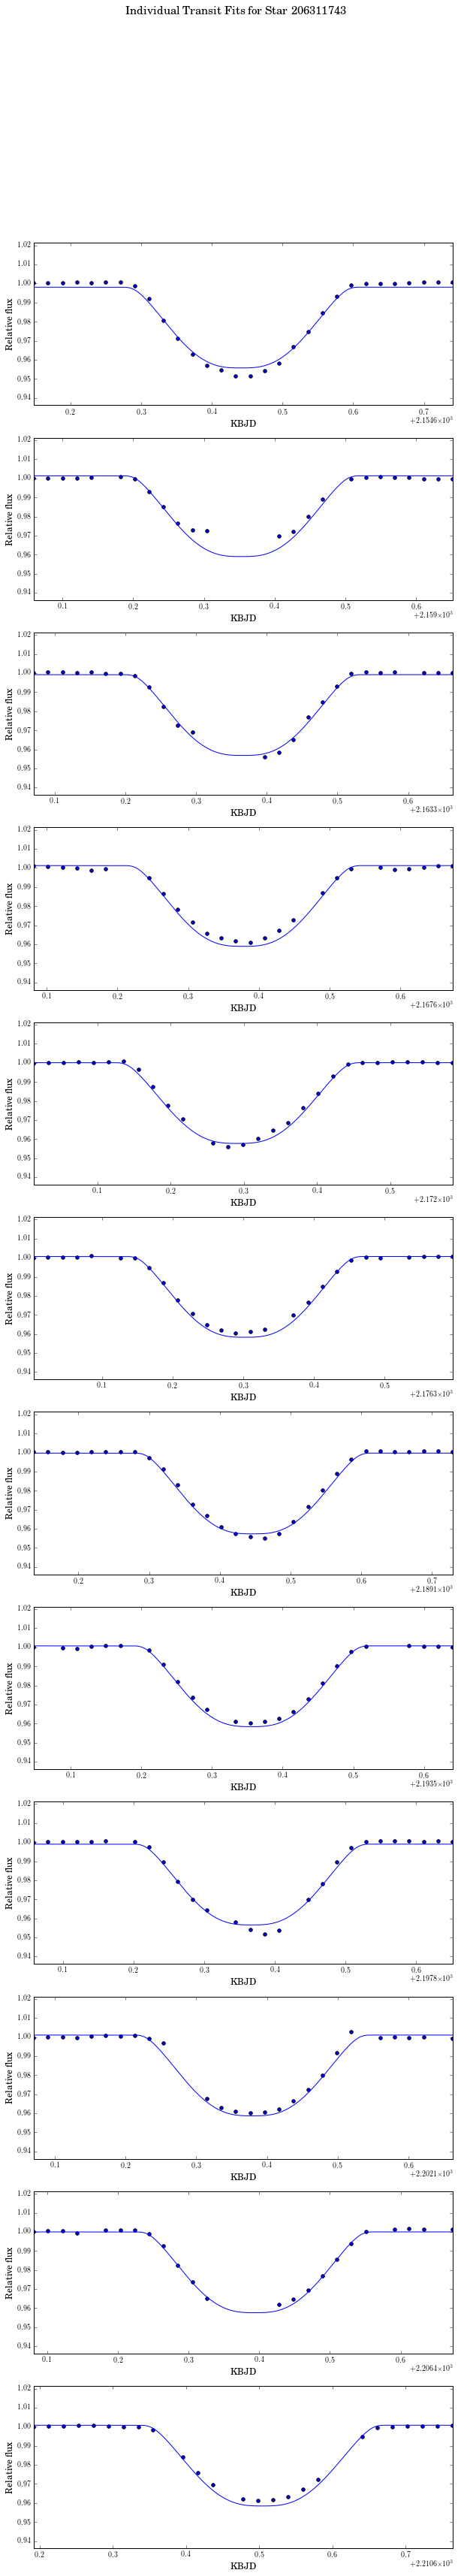

In [209]:
k = 0

for star in targets:
    parameters = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1)
    print k, ") Star ", star.name, "has", len(star.transits), "transits. Fitting results:"
    plotOptim(star, parameters)
    k+=1

In [210]:
def plotOptim(star, parameters):
    
    plt.figure(1)
    
    if len(star.transits) <= 6:
        fig = plt.figure(figsize = (10, 6))
    
    else:
        fig = plt.figure(figsize = (10, 55))    
    
    fig.suptitle('Individual Transit Fits for Star '+star.name, fontsize = 15)
             
    for i in range(len(star.transits)):
        
        s = transit.System(transit.Central(mu1 = star.lld, mu2 = star.qld, mass = parameters[5], radius = parameters[6]))
        
        body = transit.Body(r=np.sqrt(parameters[0])*parameters[6], period = star.per, 
                            t0 = star.t0fit[i], b = np.abs(parameters[1]), e = star.ecc)
        
        s.add_body(body)
 
        t_theory = np.arange(-1, 1, tKep*0.01) + star.t0fit[i]
        f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-09, maxdepth = 4)
        f_theory = (f_theory - 1.0 + star.f0fit[i]) + (star.dfdtfit[i]*(t_theory-star.t0fit[i]))
        
        
        ax = fig.add_subplot(len(star.transits),1, i+1)
        ax.scatter(star.t_trans[star.flag == i], star.f_trans[star.flag == i])
        ax.plot(t_theory, f_theory)
        
        plt.xlim([min(star.t_trans[star.flag==i]), max(star.t_trans[star.flag == i])]) 
        plt.ylim([1-star.depth*1.5, star.depth*0.5+1]) 
        
        ax.set_xlabel('KBJD', fontsize = 12)
        ax.set_ylabel('Relative flux', fontsize = 12)

    plt.show() 

Avoid the transits that Transit Module could not fit (visually inspect the plots of the individual transit fits and see the ones that lack theoretical model). 

In [223]:
def elimTrans(star, count):
    if count == 5: # Star 206038483 has 20 transits, and 3 could not be fitted. Eliminate transits 10, 12, 18. 
        star.badTrans = 3 
    if count == 10: # Star 206247743 has 14 transits, and 8 could not be fitted. Elminate transits 0, 4, 5, 6, 7, 8, 9, 10
        star.badTrans = 8 


count = 0

print "-------- Nº of bad transits --------"
print ""

for star in targets:
    elimTrans(star, count)
    
    if star.badTrans != 0:
        print count, ") Star", star.name, ":", star.badTrans, "-- !!!!"
    else:
        print count, ") Star", star.name, ":", star.badTrans
    
    count+=1

-------- Nº of bad transits --------

0 ) Star 201516974 : 0
1 ) Star 201920032 : 0
2 ) Star 205924614 : 0
3 ) Star 205985357 : 0
4 ) Star 206029314 : 0
5 ) Star 206038483 : 3 -- !!!!
6 ) Star 206061524 : 0
7 ) Star 206082454 : 0
8 ) Star 206155547 : 0
9 ) Star 206245553 : 0
10 ) Star 206247743 : 8 -- !!!!
11 ) Star 206311743 : 0


# ATTEMPT MCMC WITHOUT BAD TRANSITS 

In [227]:
def mcmc_inside(star, i, count1, allfixed):
    ndim, nwalkers = 4, 100 # ndim = Nº of fitted parameters (t0, f0, dfdt, sigma)
    steps = 1000

    pos = [[star.t0fit[i], star.f0fit[i], star.dfdtfit[i], 
            star.sigmafit[i]]*(1 + 1e-5*np.random.randn(ndim)) for j in range(nwalkers)]
                
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike2, 
                                        args = (i, star.t_trans[star.flag==i], star.f_trans[star.flag==i], 
                                                0.1*star.error_foldedLC, allfixed))

    sampler.run_mcmc(pos, steps)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

    fig = corner.corner(samples, labels=["t0","f0","dfdt","sigma"])

    v1 = np.percentile(samples[:,0], [15.84, 50, 84.16], axis=0)
    t0_inside[count1,0] = v1[1] # 3rd value is the best estimate for t0 (it falls at the center)
    t0_inside[count1,1] = v1[2] - v1[1] #+ Error of t0
    t0_inside[count1,2] = v1[1] - v1[0] #- Error of t0

    v2 = np.percentile(samples[:,1], [15.84, 50, 84.16], axis=0)
    f0fit_inside[count1,0] = v2[1] # 3rd value is the best estimate for f0
    f0fit_inside[count1,1] = v2[2] - v2[1] #+ Error of f0
    f0fit_inside[count1,2] = v2[1] - v2[0] #- Error of f0

    v3 = np.percentile(samples[:,2],[15.84, 50, 84.16], axis=0)
    dfdtfit_inside[count1,0] = v2[1] # 3rd value is the best estimate for df/dt
    dfdtfit_inside[count1,1] = v2[2] - v2[1] #+ Error of df/dt
    dfdtfit_inside[count1,2] = v2[1] - v2[0] #- Error of df/dt

    v4 = np.percentile(samples[:,3],[15.84, 50, 84.16], axis=0)
    sigmafit_inside[count1,0] = v3[1] # 3rd value is the best estimate for sigma
    sigmafit_inside[count1,1] = v3[2] - v3[1] #+ Error of sigma
    sigmafit_inside[count1,2] = v3[1] - v3[0] #- Error of sigma

    return t0fit_inside, f0fit_inside, dfdtfit_inside, sigmafit_inside        

def mcmc(star, a, allfixed):
    count1 = 0
    
    t0fit_mcmc = np.zeros((len(star.transits) - star.badTrans, 3)) # nº columns = 3 (1st = best guess, 2nd = upper error, 3rd = lower error)
    f0fit_mcmc = np.zeros((len(star.transits) - star.badTrans, 3))
    dfdtfit_mcmc = np.zeros((len(star.transits) - star.badTrans, 3))
    sigmafit_mcmc = np.zeros((len(star.transits) - star.badTrans, 3))
    
    if a == 5: # if star 206038483
        for i in range(len(star.transits)):
            if (i !=10 and i!=12 and i!=18):
                t0fit_mcmc, f0fit_mcmc, dfdtfit_mcmc, sigmafit_mcmc = mcmc_inside(star, i, count1, allfixed)
                count1 += 1
        
    if a == 10: # if star 206247743
        for i in range(len(star.transits)):
            if (i != 0 and i!=4 and i!=5 and i!=6 and i!=7 and i!=8 and i!=9 and i!= 10):
                t0fit_mcmc, f0fit_mcmc, dfdtfit_mcmc, sigmafit_mcmc = mcmc_inside(star, i, count1, allfixed)
                count1 += 1
    
    else: 
        for i in range(len(star.transits)):
            t0fit_mcmc, f0fit_mcmc, dfdtfit_mcmc, sigmafit_mcmc = mcmc_inside(star, i, count1, allfixed)
            count1 += 1

    star.t0fit_MCMC = t0fit_mcmc 
    star.f0fit_MCMC = f0fit_mcmc
    star.dfdtfit_MCMC = dfdtfit_mcmc
    star.sigmafit_MCMC = sigmafit_mcmc

In [ ]:
a = 0

for star in targets:
    parameters = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1)
    allfixed = loadParams(parameters, star)
    mcmc(star, a, allfixed)
    printMCMC(star)
    a+=1

In [229]:
def printMCMC(star):
    print ""
    print "------ For Star ", star.name, "------"
    print "MCMC for t0:", star.t0fit_MCMC
    print "MCMC for f0:", star.f0fit_MCMC
    print "MCMC for df/dt:", star.dfdtfit_MCMC
    print "MCMC for sigma:", star.sigmafit_MCMC

## MCMC

In [ ]:
for star in targets:
    #mcmc(star)
    #printMCMC(star)

With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

In [ ]:
def mcmc(star):
    
    ndim, nwalkers = 4, 100 # 4 =  N'º of fitted parameters (t0, f0, dfdt, sigma)
    steps = 1000

    """Structure of the following matrices: 
         nº of rows = len(star.transits), so each row corresponds to a specific transit. 
         nº of columns = 3 --> 1st column = best estimate, 2nd column = upper error, 3rd column = lower error. 
    """
    
    t0fit_mcmc = np.zeros((len(star.transits),3)) 
    f0fit_mcmc = np.zeros((len(star.transits),3))
    dfdtfit_mcmc = np.zeros((len(star.transits),3))
    sigmafit_mcmc = np.zeros((len(star.transits),3))
    
    for i in range(len(star.transits)):
        
        pos = [[star.t0fit[i], star.f0fit[i], star.dfdtfit[i], star.sigmafit[i]]*(1 + 1e-5*np.random.randn(ndim)) for j in range(nwalkers)]
        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike2, 
                                        args = (i, star.t_trans[star.flag==i], star.f_trans[star.flag==i], 
                                                0.1*star.error_foldedLC, allfixed))

        sampler.run_mcmc(pos, steps)
        samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

        fig = corner.corner(samples, labels=["t0","f0","dfdt","sigma"])

        v1 = np.percentile(samples[:,0], [15.84, 50, 84.16], axis = 0)
        t0fit_mcmc[i,0] = v1[1] # 3rd value is the best estimate for t0 (it falls at the center)
        t0fit_mcmc[i,1] = v1[2]-v1[1] #+ Error of t0
        t0fit_mcmc[i,2] = v1[1]-v1[0] #- Error of t0
        
        v2 = np.percentile(samples[:,1], [15.84, 50, 84.16], axis = 0)
        f0fit_mcmc[i,0] = v2[1] # 3rd value is the best estimate for f0
        f0fit_mcmc[i,1] = v2[2]-v2[1] #+ Error of f0
        f0fit_mcmc[i,2] = v2[1]-v2[0] #- Error of f0

        v3 = np.percentile(samples[:,2],[15.84, 50, 84.16], axis = 0)
        dfdtfit_mcmc[i,0] = v2[1] # 3rd value is the best estimate for df/dt
        dfdtfit_mcmc[i,1] = v2[2]-v2[1] #+ Error of df/dt
        dfdtfit_mcmc[i,2] = v2[1]-v2[0] #- Error of df/dt

        v4 = np.percentile(samples[:,3],[15.84, 50, 84.16], axis = 0)
        sigmafit_mcmc[i,0] = v3[1] # 3rd value is the best estimate for sigma
        sigmafit_mcmc[i,1] = v3[2]-v3[1] #+ Error of sigma
        sigmafit_mcmc[i,2] = v3[1]-v3[0] #- Error of sigma
      
    star.t0fit_MCMC = t0fit_mcmc 
    star.f0fit_MCMC = f0fit_mcmc
    star.dfdtfit_MCMC = dfdtfit_mcmc
    star.sigmafit_MCMC = sigmafit_mcmc

Print the estimates for t0 (time of transit), f0 (flux outside the transit), df/dt, and sigma. The second 
column gives the upper error and the third the lower error.

In [87]:
def printMCMC(star):
    print "---- For Star ", star.name, "----"
    print "MCMC for t0:", star.t0fit_MCMC
    print "MCMC for f0:", star.f0fit_MCMC
    print "MCMC for df/dt:", star.dfdtfit_MCMC
    print "MCMC for sigma:", star.sigmafit_MCMC

## Period and Transit Time determination & OC residuals

"""
def p_and_t0(star):
    n = []
    tobs = []
    tobsErr = []
    
    for i in range (len(star.transits)):
        aux = star.t0fit_MCMC[0]
        auxerr = (star.t0fit_MCMC[1] + star.t0fit_MCMC[2])/2
        n.append(i)
        tobs.append(aux)
        tobsErr.append(auxerr)

    k = np.polyfit(n, tobs, 1)
    slopeP = k[0]
    t0Final = k[1]

    def func(x, a, b): 
        return (a*x + b)

    tobserr = np.array(tobsErr) # Convert list to array
    popt, pcov = op.curve_fit(func, n, tobs, p0 = [slopeP, t0Final], sigma = tobserr)

    """
        popt: Optimal values for the parameters so that the sum of the squared error of "f(xdata, *popt) - ydata" is
        minimized. (Array)

        pcov: The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute
        one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)). (2D Array)
    """

    perr = np.sqrt(np.diag(pcov))
    print "---------- For Star ", star.name, "----------"
    print "Optimal parameters (period and t0):", popt
    print "Respective Uncertainties:", perr

    t_y = np.array(tobs) - popt[1] - popt[0]*np.array(n)

    upper_error = t0fit_mcmc[:,1]
    lower_error = t0fit_mcmc[:,2]
    asymmetric_error = [lower_error, upper_error]

chi2_aux=[]

for i in range(0,len(t_y)):
    meanError = (upper_error[i]+lower_error[i])/2
    ratio = t_y[i]/meanError
    chi2_aux.append(ratio)
    
chi2_OC = 0
for j in range(0,len(chi2_aux)):
    chi2_OC = chi2_OC + (chi2_aux[j]**2)

print "Chi squared:", chi2_OC

plt.figure(5)
plt.errorbar(tobs, t_y, yerr=asymmetric_error, fmt='o')
plt.xlabel('T obs(n)')
plt.ylabel('O-C Residuals (days)') #Residuals t obs(n) - t0 - P*n'
plt.title('Residuals', fontsize = 18)
plt.savefig('2_201920032OC.png')
#plt.show()
"""